<a href="https://colab.research.google.com/github/partha1189/machine_learning/blob/tf_2.0_practice/CNN_Tranfer_Learning_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
from tensorflow.keras.applications.inception_v3 import InceptionV3

--2020-09-18 10:22:28--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.20.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   167MB/s    in 0.5s    

2020-09-18 10:22:29 (167 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
!ls -l /tmp

total 85852
-rw-r--r-- 1 root root 87910968 Mar 28  2018 inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


In [3]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [4]:
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top = False,
                                weights = None)

In [5]:
pre_trained_model.load_weights(local_weights_file)

In [6]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [7]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [9]:
from tensorflow.keras.optimizers import RMSprop

#set outputs of the model
x = layers.Flatten()(last_output)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dropout(0.2)(x)

x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])


In [10]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

--2020-09-18 10:22:37--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.195.128, 74.125.28.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   179MB/s    in 0.4s    

2020-09-18 10:22:38 (179 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [12]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


In [13]:

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150, 150),
                                                    batch_size = 20,
                                                    class_mode = 'binary')

Found 2000 images belonging to 2 classes.


In [14]:
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [15]:
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 1000 images belonging to 2 classes.


In [16]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 100,
                    epochs = 20,
                    validation_steps = 50,
                    verbose =2)

Epoch 1/20
100/100 - 19s - loss: 0.3595 - accuracy: 0.8610 - val_loss: 0.0957 - val_accuracy: 0.9670
Epoch 2/20
100/100 - 18s - loss: 0.2198 - accuracy: 0.9085 - val_loss: 0.1102 - val_accuracy: 0.9600
Epoch 3/20
100/100 - 18s - loss: 0.1908 - accuracy: 0.9265 - val_loss: 0.1078 - val_accuracy: 0.9630
Epoch 4/20
100/100 - 18s - loss: 0.1860 - accuracy: 0.9280 - val_loss: 0.1077 - val_accuracy: 0.9670
Epoch 5/20
100/100 - 18s - loss: 0.2065 - accuracy: 0.9285 - val_loss: 0.0877 - val_accuracy: 0.9720
Epoch 6/20
100/100 - 18s - loss: 0.1868 - accuracy: 0.9340 - val_loss: 0.1012 - val_accuracy: 0.9650
Epoch 7/20
100/100 - 17s - loss: 0.1796 - accuracy: 0.9450 - val_loss: 0.1696 - val_accuracy: 0.9490
Epoch 8/20
100/100 - 17s - loss: 0.1706 - accuracy: 0.9430 - val_loss: 0.2373 - val_accuracy: 0.9360
Epoch 9/20
100/100 - 17s - loss: 0.1677 - accuracy: 0.9455 - val_loss: 0.1624 - val_accuracy: 0.9560
Epoch 10/20
100/100 - 17s - loss: 0.1686 - accuracy: 0.9470 - val_loss: 0.1265 - val_accura

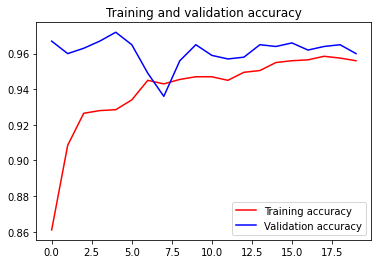

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()